# Feature Engineering Checker
To guarantee the correctness of the feature engineering results used in modeling process, thie notebook aims at providing the verification. Furthermore, the exploration of new features is also implemented here. Code snippets related to EDA during the exploration will be moved to `eda.ipynb`.
<div class="alert alert-block alert-danger">
    <p>Feature engineering isn't constrained in the range of <strong>legitimate</strong> <code>shop_tag</code>s,
       others may also be helpful.
    </p> 
</div>

In [1]:
# Import packages
import os 
import pickle
from tqdm import tqdm_notebook as tqdm
import warnings
from joblib import Parallel, delayed


import yaml
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from metadata import *
from fe import *
from utils.dataset_generator import DataGenerator

# Configuration
pd.set_option('max_columns', 150)
warnings.simplefilter('ignore')

## Transaction

In [4]:
# Prepare data 
df = pd.read_parquet("./data/raw/raw_data.parquet", columns=PK+['txn_cnt', 'txn_amt'])
with open("./data/processed/purch_maps.pkl", 'rb') as f:
    purch_maps = pickle.load(f)
display(df.head(1))
print(f"Let's observe the purchasing map of client 10000000 \n{purch_maps[10000000]}")

,dt,chid,shop_tag,txn_cnt,txn_amt
0,1,10321418,45,3,3891.965283


Let's observe the purchasing map of client 10000000 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


### Time Since **First** Transaction of Each `shop_tag`

In [4]:
DTS_BASE = np.array([DTS]).T

In [5]:
# Check
def get_gap_since_first_txn(t_end, purch_map):
    '''Return time gap since first transaction of each shop_tag for a 
    single client.
    
    Zeros in the vector indicate that client has made his/her first 
    txn on that shop_tag at t_end. And one hundreds indicate that 
    client hasn't made a txn on that shop_tag so far.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 
    
    Return:
        gap_vec: ndarray, vector including time gap since the first 
                 transaction of each shop_tag
    '''
    purch_map = purch_map[:t_end, :]
    purch_map = purch_map * DTS_BASE[:t_end]
    purch_map = np.where(purch_map == 0, 25, purch_map)
    gap_vec = np.min(purch_map, axis=0)
    gap_vec = t_end - gap_vec
    gap_vec = np.where(gap_vec < 0, 100, gap_vec)    
    gao_vec = gap_vec.astype(np.int8)
    
    return gap_vec

In [6]:
for chid, purch_map in tqdm(purch_maps.items()):
    get_gap_since_first_txn(t_end=24, purch_map=purch_map)

100%|██████████| 500000/500000 [00:07<00:00, 63495.64it/s]


### Time Since **Last** Transaction of Each `shop_tag`

In [7]:
# Check
def get_gap_since_last_txn(t_end, purch_map):
    '''Return time gap since last transaction of each shop_tag for a 
    single client.
    
    Zeros in the vector indicate that client has made a transaction at
    t_end. And one hundreds indicate that client hasn't made a txn on
    that shop_tag so far.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 
    
    Return:
        gap_vec: ndarray, vector including time gap since last txn of  
                 each shop_tag
    '''
    purch_map = purch_map[:t_end, :]
    purch_map = purch_map * DTS_BASE[:t_end]
    purch_map = np.where(purch_map == 0, -100, purch_map)
    gap_vec = np.max(purch_map, axis=0)
    gap_vec = t_end - gap_vec
    gap_vec = np.where(gap_vec > 24, 100, gap_vec)    
    gao_vec = gap_vec.astype(np.int8)
    
    return gap_vec

In [8]:
for chid, purch_map in tqdm(purch_maps.items()):
    get_gap_since_last_txn(t_end=24, purch_map=purch_map)

100%|██████████| 500000/500000 [00:07<00:00, 63031.16it/s]


### Average Transaction Gap of Each `shop_tag`

In [9]:
# Check
def get_avg_txn_gap_vec(t_end, chid, purch_map):
    '''Return vector indicating average gap between transactions of 
    each shop_tag for a single client.
    *Note: Gap indicates the reciprocal of frequency.
    
    Time gap here is a little bit different from other two txn time gap
    features, gap_since_first and gap_since_last. Gap here indicates
    #months between two consecutive transactions.
    
    For example:
        dt  20  21  22  23  24
            V   X   X   X   V   ---->  time_gap == 3
            
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        chid: int, client identifier
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 

    Return:
        chid: int, client identifier
        gap_vec: ndarray, average transaction gap of each shop_tag
    '''
    gap_vec = []
    purch_map = purch_map[:t_end, :]
    purch_map = purch_map * DTS_BASE[:t_end]
    for purch_vec in purch_map.T:
        # For purchasing vector of each shop_tag
        purch_vec_ = purch_vec[purch_vec != 0]
        avg_gap = np.mean(np.diff(purch_vec_, n=1) - 1)   # -1 to help interpret the concept 'gap'
        gap_vec.append(avg_gap)
    gap_vec = np.array(gap_vec)
    gap_vec = np.nan_to_num(gap_vec, nan=100)

    return chid, gap_vec

In [10]:
gap_vecs = Parallel(n_jobs=-1)(
    delayed(get_avg_txn_gap_vec)(24, chid, purch_map) 
    for chid, purch_map in tqdm(purch_maps.items())
)

100%|██████████| 500000/500000 [01:04<00:00, 7722.06it/s]


### Transaction State Toggles

In [11]:
# Check
def get_txn_st_tgl_mat(t_end, chid, purch_map):
    '''Return counts of transaction state toggles, including 0/0, 0/1,
    1/0, 1/1, total 4 state transitions.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        chid: int, client identifier
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 

    Return:
        chid: int, client identifier
        st_tgl_mat: ndarray, counts of state transitions, with shape 
                    (4, n_shop_tags)
    '''
    st_tgl_mat = []
    purch_map = purch_map[:t_end, :]
    for purch_vec in purch_map.T:
        # For purchasing vector of each shop_tag
        n_10 = abs(np.sum((purch_vec - 1)[1:] * purch_vec[:-1]))
        n_01 = abs(np.sum((purch_vec - 1)[:-1] * purch_vec[1:]))
        n_11 = abs(np.sum(purch_vec[:-1] * purch_vec[1:]))
        n_00 = (t_end-1) - n_10 - n_01 - n_11
        st_tgl_mat.append([n_00, n_01, n_10, n_11])
    st_tgl_mat = np.array(st_tgl_mat).T
    
    return chid, st_tgl_mat

In [12]:
st_tgl_mats = Parallel(n_jobs=-1)(
    delayed(get_txn_st_tgl_mat)(24, chid, purch_map) 
    for chid, purch_map in tqdm(purch_maps.items())
)

100%|██████████| 500000/500000 [01:04<00:00, 7746.05it/s]


### % of Months Each `shop_tag` Having Txn Records

In [17]:
# Check
def get_txn_made_ratio_vec(t_end, purch_map):
    '''Return ratio of months txn records exist for each shop_tag for 
    a single client.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 

    Return:
        txn_made_ratio_vec: ndarray, ratio of months txn records exist
                            for each shop_tag
    '''
    purch_map = purch_map[:t_end, :]
    txn_made_ratio_vec = np.sum(purch_map, axis=0) / t_end
    
    return txn_made_ratio_vec

In [18]:
for chid, purch_map in tqdm(purch_maps.items()):
    get_txn_made_ratio_vec(t_end=24, purch_map=purch_map)

100%|██████████| 500000/500000 [00:04<00:00, 121896.73it/s]


### #`shop_tag`s Per Month 

In [2]:
# Check
def get_n_shop_tags_vec(t_end, purch_map, leg_only):
    '''Return number of shop_tags having txn records for each month
    for a single client.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 
        leg_only: bool, whether to consider legitimate shop_tags only 

    Return:
        n_shop_tags_vec: ndarray, num of shop_tags having txn records 
                         for each month
    '''
    purch_map = purch_map[:t_end, :]
    purch_map = purch_map[:, LEG_SHOP_TAGS_INDICES] if leg_only else purch_map
    n_shop_tags_vec = np.sum(purch_map, axis=1)
    
    return n_shop_tags_vec

In [14]:
for chid, purch_map in tqdm(purch_maps.items()):
    get_n_shop_tags_vec(24, purch_map, False)

100%|██████████| 500000/500000 [00:02<00:00, 177607.90it/s]


### Purchasing Vector of the Last Month

In [15]:
# Check
def get_purch_vec_t_end(t_end, purch_map):
    '''Directly return purchasing vector at t_end, the nearest purch
    behavior.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 

    Return:
        purch_vec: ndarray, purchasing vector at t_end
    '''
    purch_vec = purch_map[t_end-1]   # -1 to align with index    
    
    return purch_vec

In [16]:
for chid, purch_map in tqdm(purch_maps.items()):
    get_purch_vec_t_end(t_end=24, purch_map=purch_map)

100%|██████████| 500000/500000 [00:00<00:00, 2371568.57it/s]


In [2]:
# Variable definitions (notice the collision with metadata)
non_card_feats = [feat for feat in COLS if 'card' not in feat]

## None-Card
This section focuses on features irrelevant to `card` information. 

In [5]:
# Prepare raw data
df = pd.read_parquet("./data/raw/raw_data.parquet", columns=non_card_feats)
df.head()

,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,domestic_offline_amt_pct,domestic_online_amt_pct,overseas_offline_amt_pct,overseas_online_amt_pct,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age
0,1,10321418,45,3,3891.965283,3,0,0,0,1.00,0.00,0.0,0.0,1,4,5,1,99,30,95982.822967,1,4
1,1,10414574,15,2,10616.561549,2,0,0,0,1.00,0.00,0.0,0.0,2,2,15,1,2,30,130702.351368,1,3
2,1,10134567,48,2,23527.655416,0,2,0,0,0.00,1.00,0.0,0.0,1,3,11,1,3,30,112010.611717,0,4
3,1,10001003,48,9,17751.558260,7,2,0,0,0.75,0.25,0.0,0.0,2,3,11,1,2,30,59701.507360,0,3
4,1,10267183,2,1,21701.307598,1,0,0,0,1.00,0.00,0.0,0.0,2,6,15,1,99,30,0.000000,0,6


The reason why percentage of all the transaction channels doesn't add to one is because of the data processing done by *Esun*, which decides to **round values to second decimal place**.

In [1]:
# Check if percentages of transaction channels add to 1
ch_cols = [col for col in df.columns if 'pct' in col]
ch_sum = np.sum(df[ch_cols].values, axis=1)
assert np.sum(ch_sum == 1) == len(ch_sum), ("There are some samples' pct of"
       " channels not adding to 1.")

NameError: name 'df' is not defined

In [26]:
# Check the discrepancy between sum values and 1, verifying that 
# the rounding action doesn't cause any error.
indices = np.nonzero((abs(ch_sum - 1) > 0.011))[0] 
df_ = df.iloc[indices, :-9]
df_.head()

,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,domestic_offline_amt_pct,domestic_online_amt_pct,overseas_offline_amt_pct,overseas_online_amt_pct


### Client-Specific Features


In [29]:
ch_cols_for_fe = [col for col in df.columns if ('cnt' in col) and (col != 'txn_cnt')] + \
                 [col for col in ch_cols if col != 'overseas_offline_amt_pct']
ch_cols_for_fe

['domestic_offline_cnt',
 'domestic_online_cnt',
 'overseas_offline_cnt',
 'overseas_online_cnt',
 'domestic_offline_amt_pct',
 'domestic_online_amt_pct',
 'overseas_online_amt_pct']

In [ ]:
df.groupby(by=['chid'])

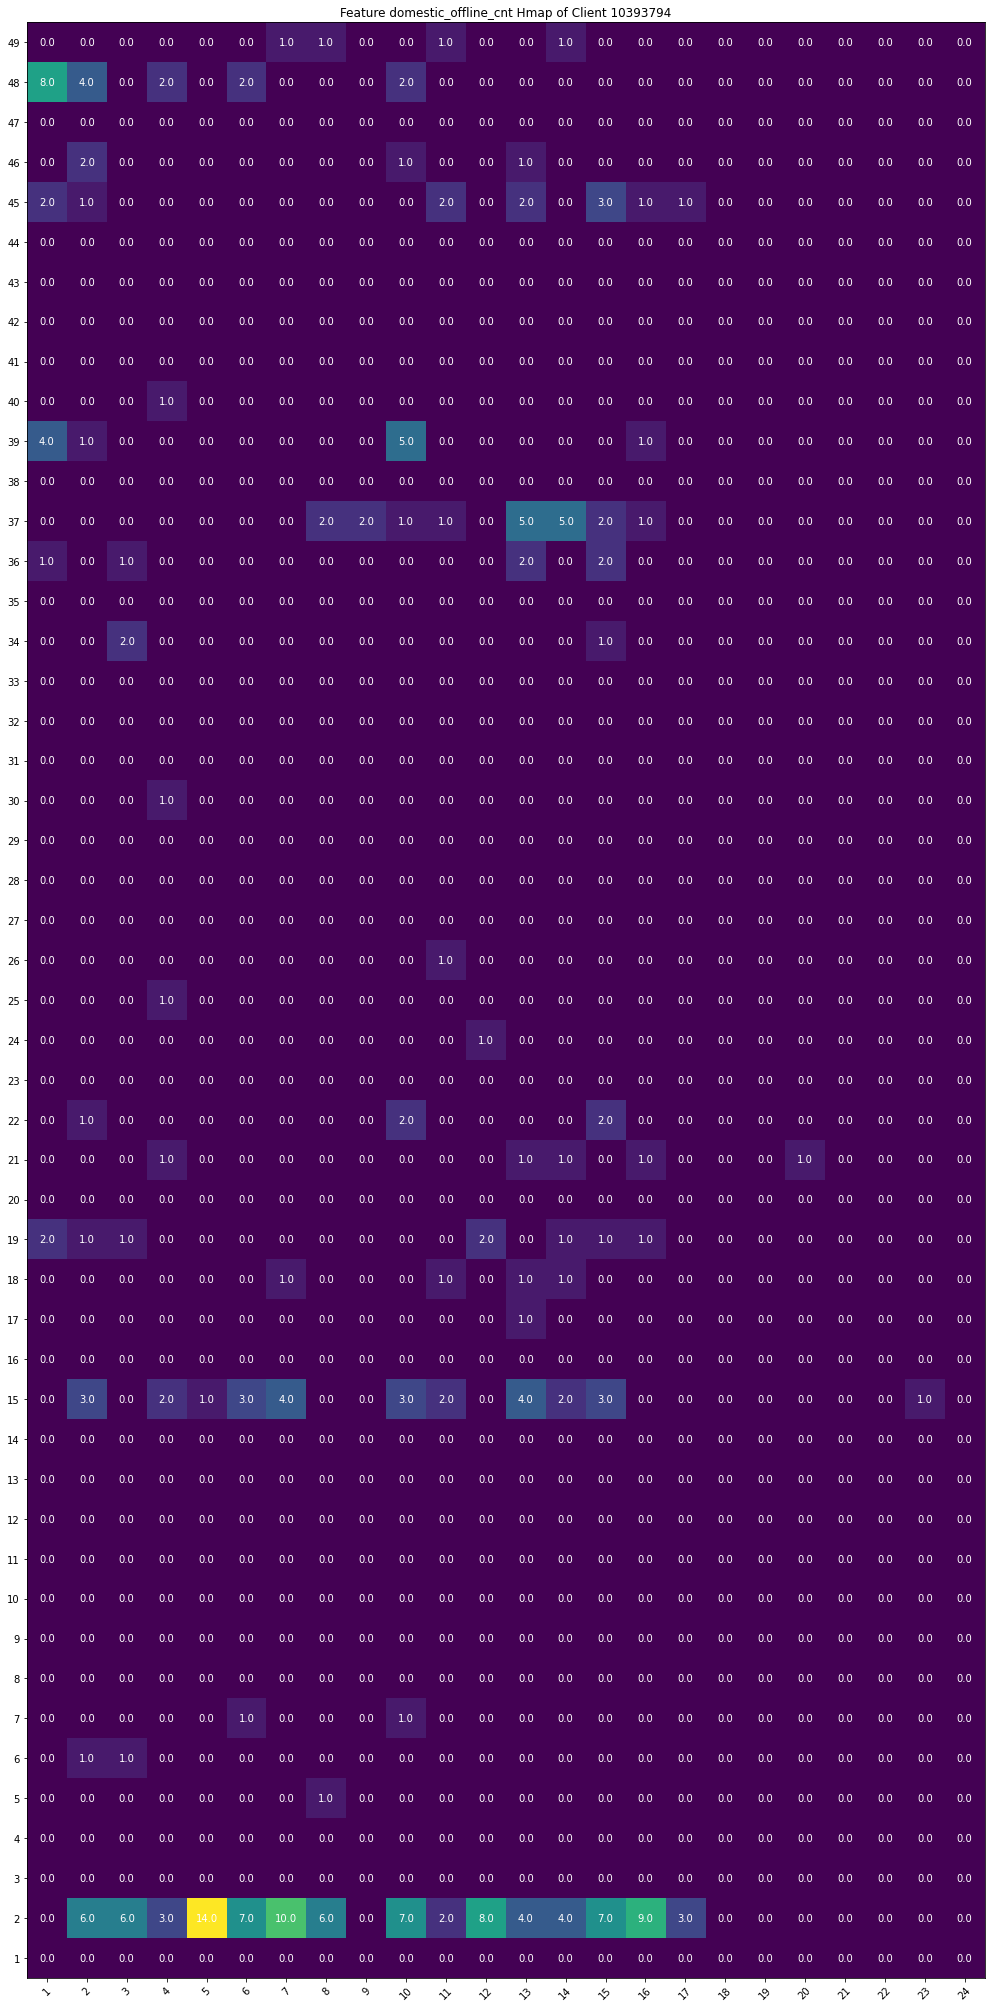

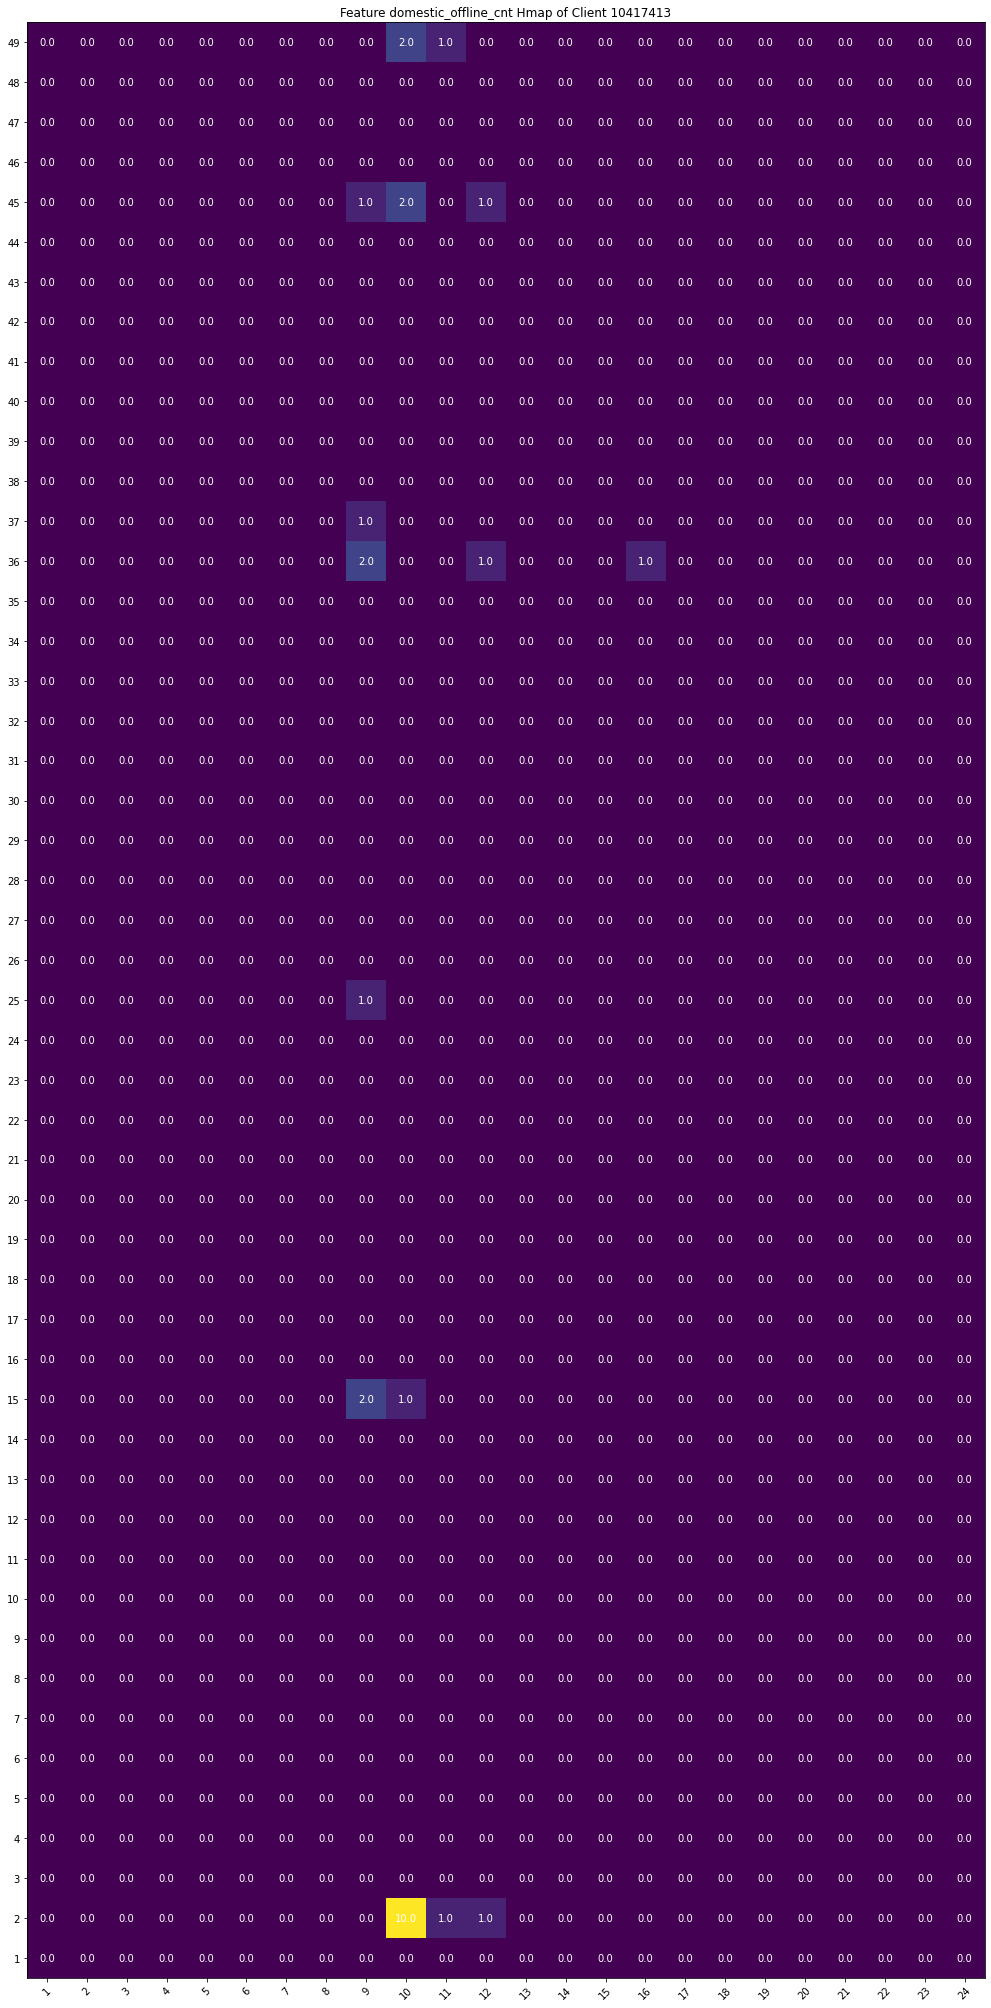

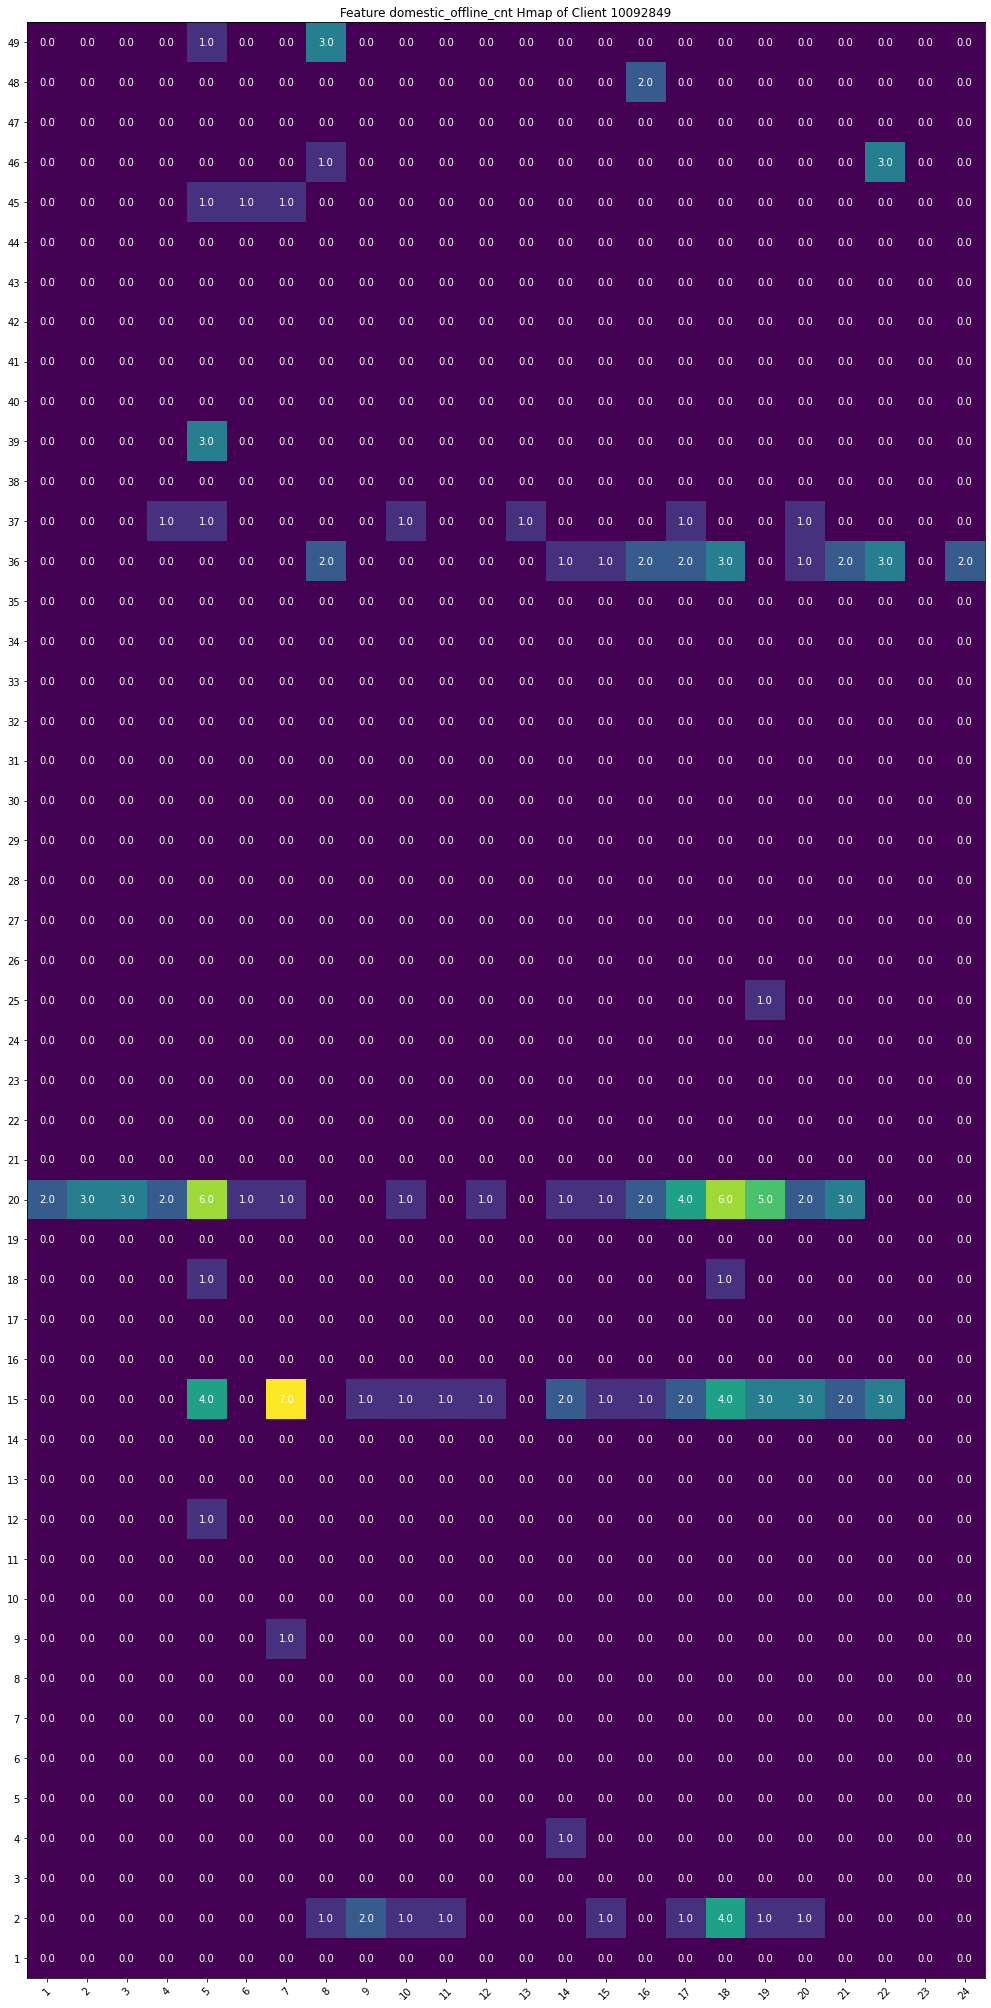

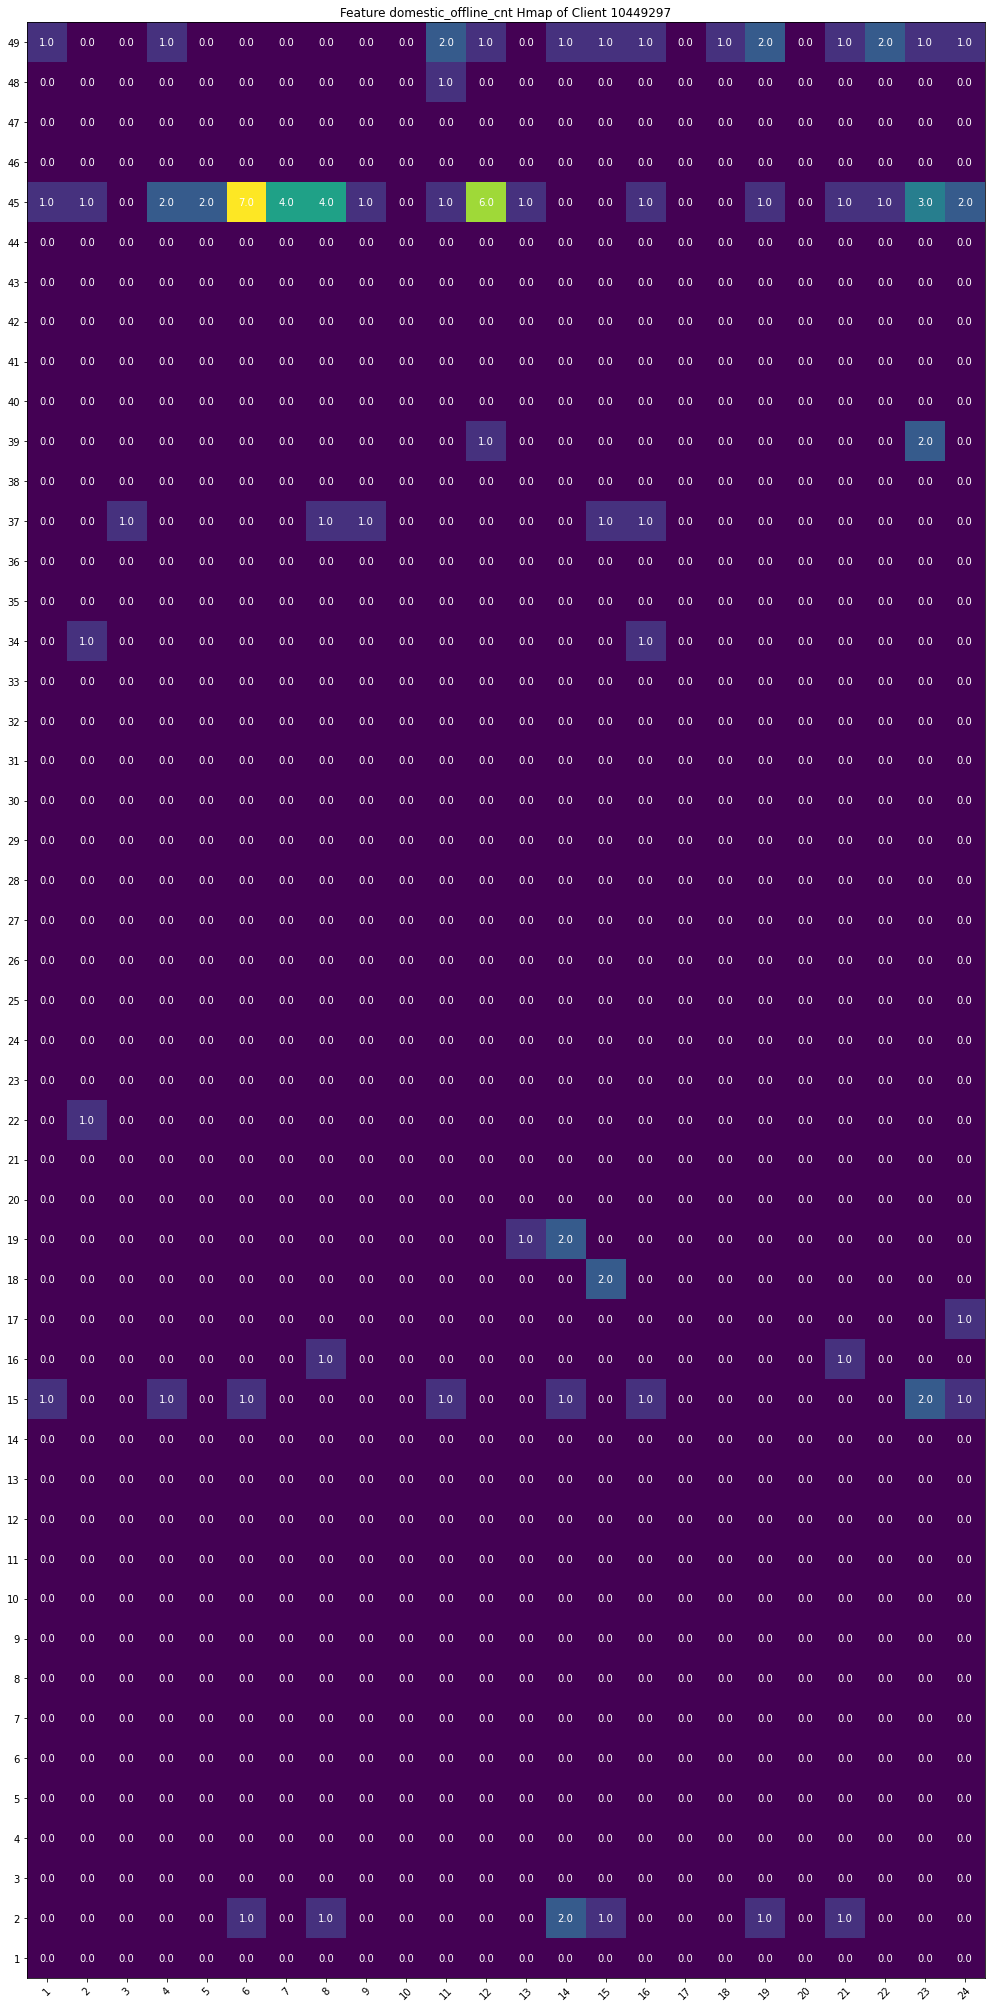

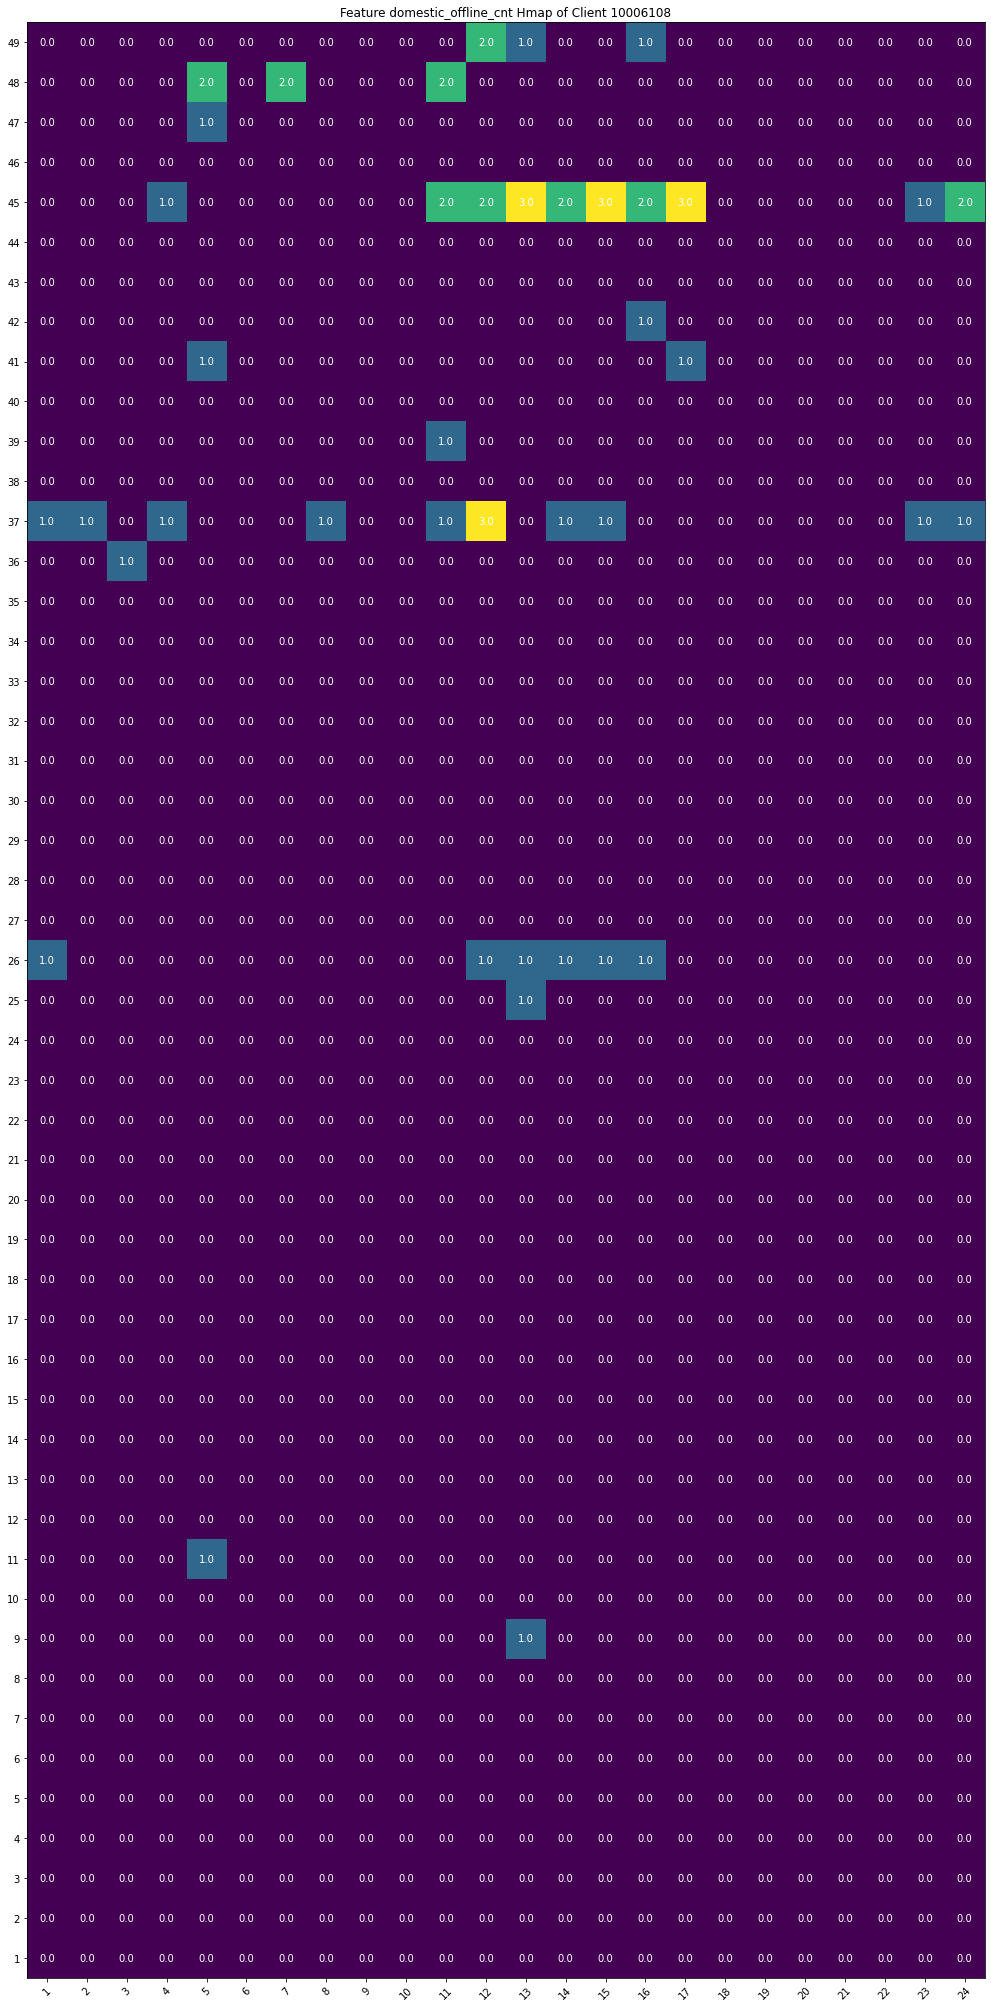

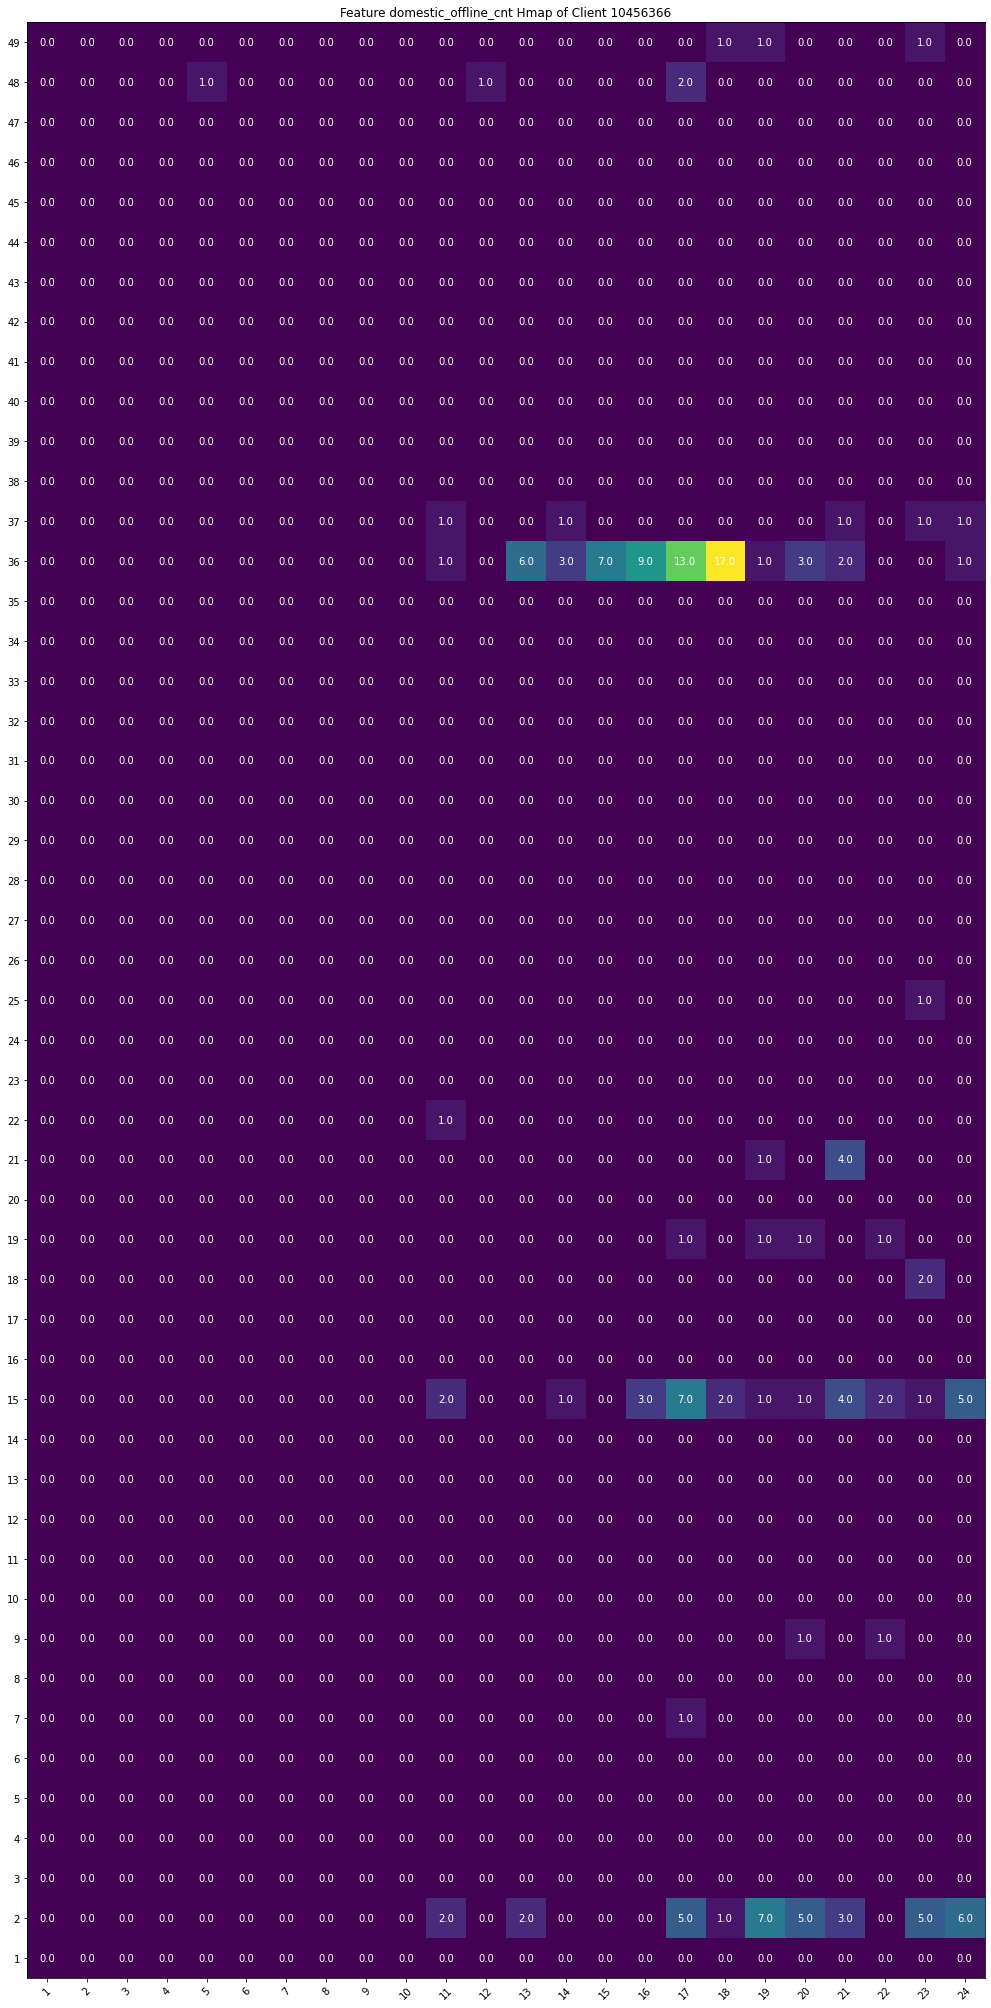

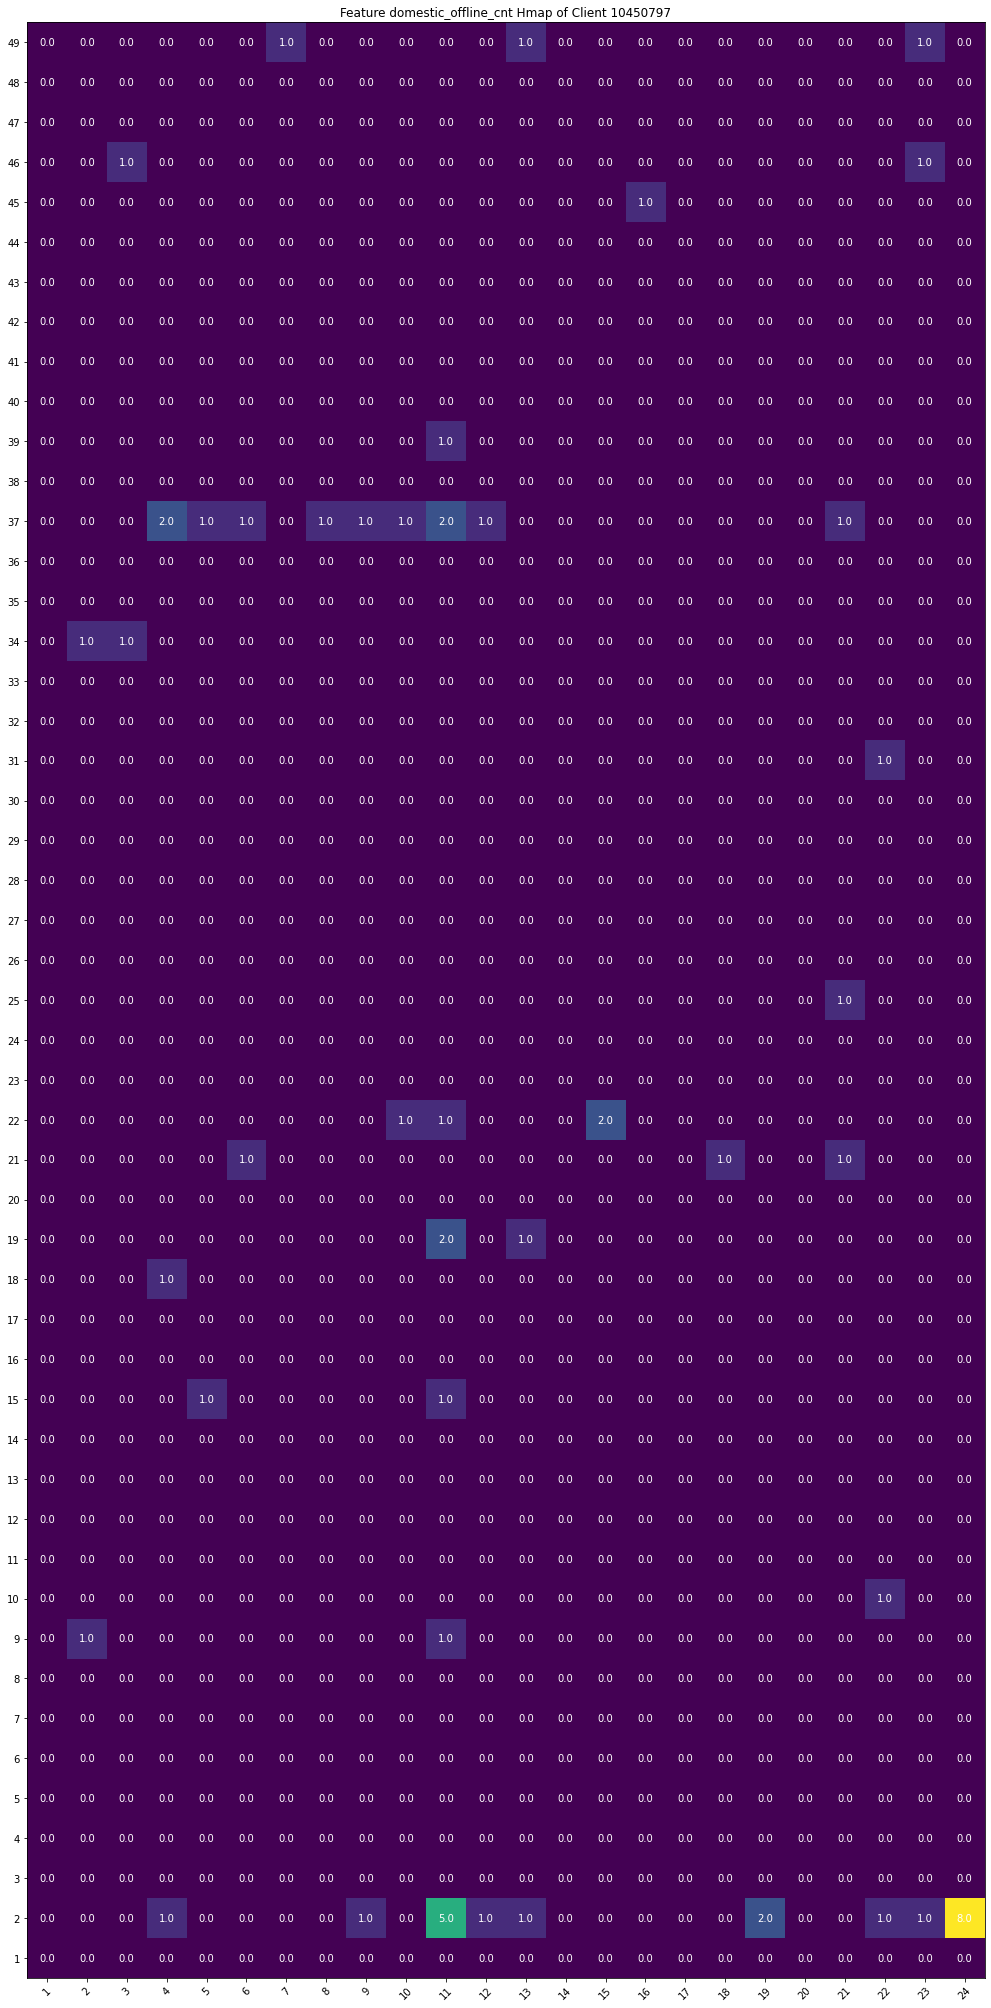

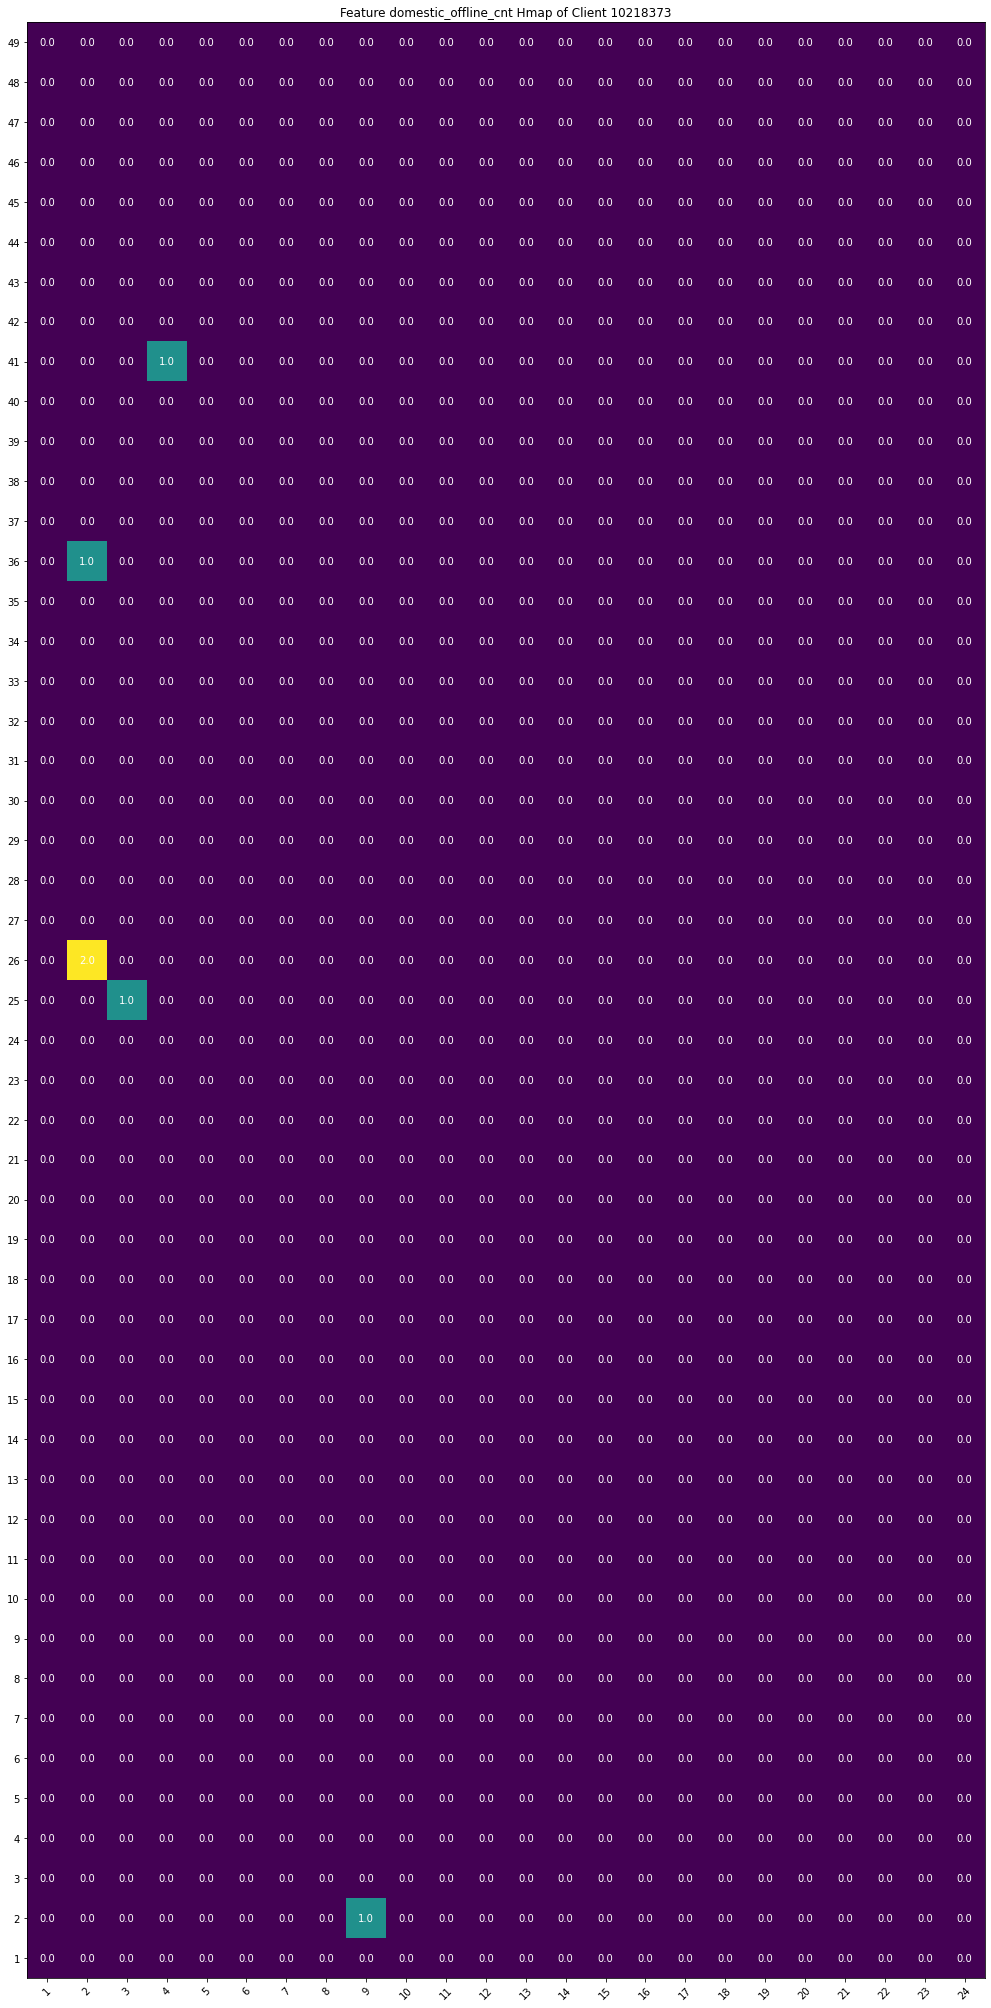

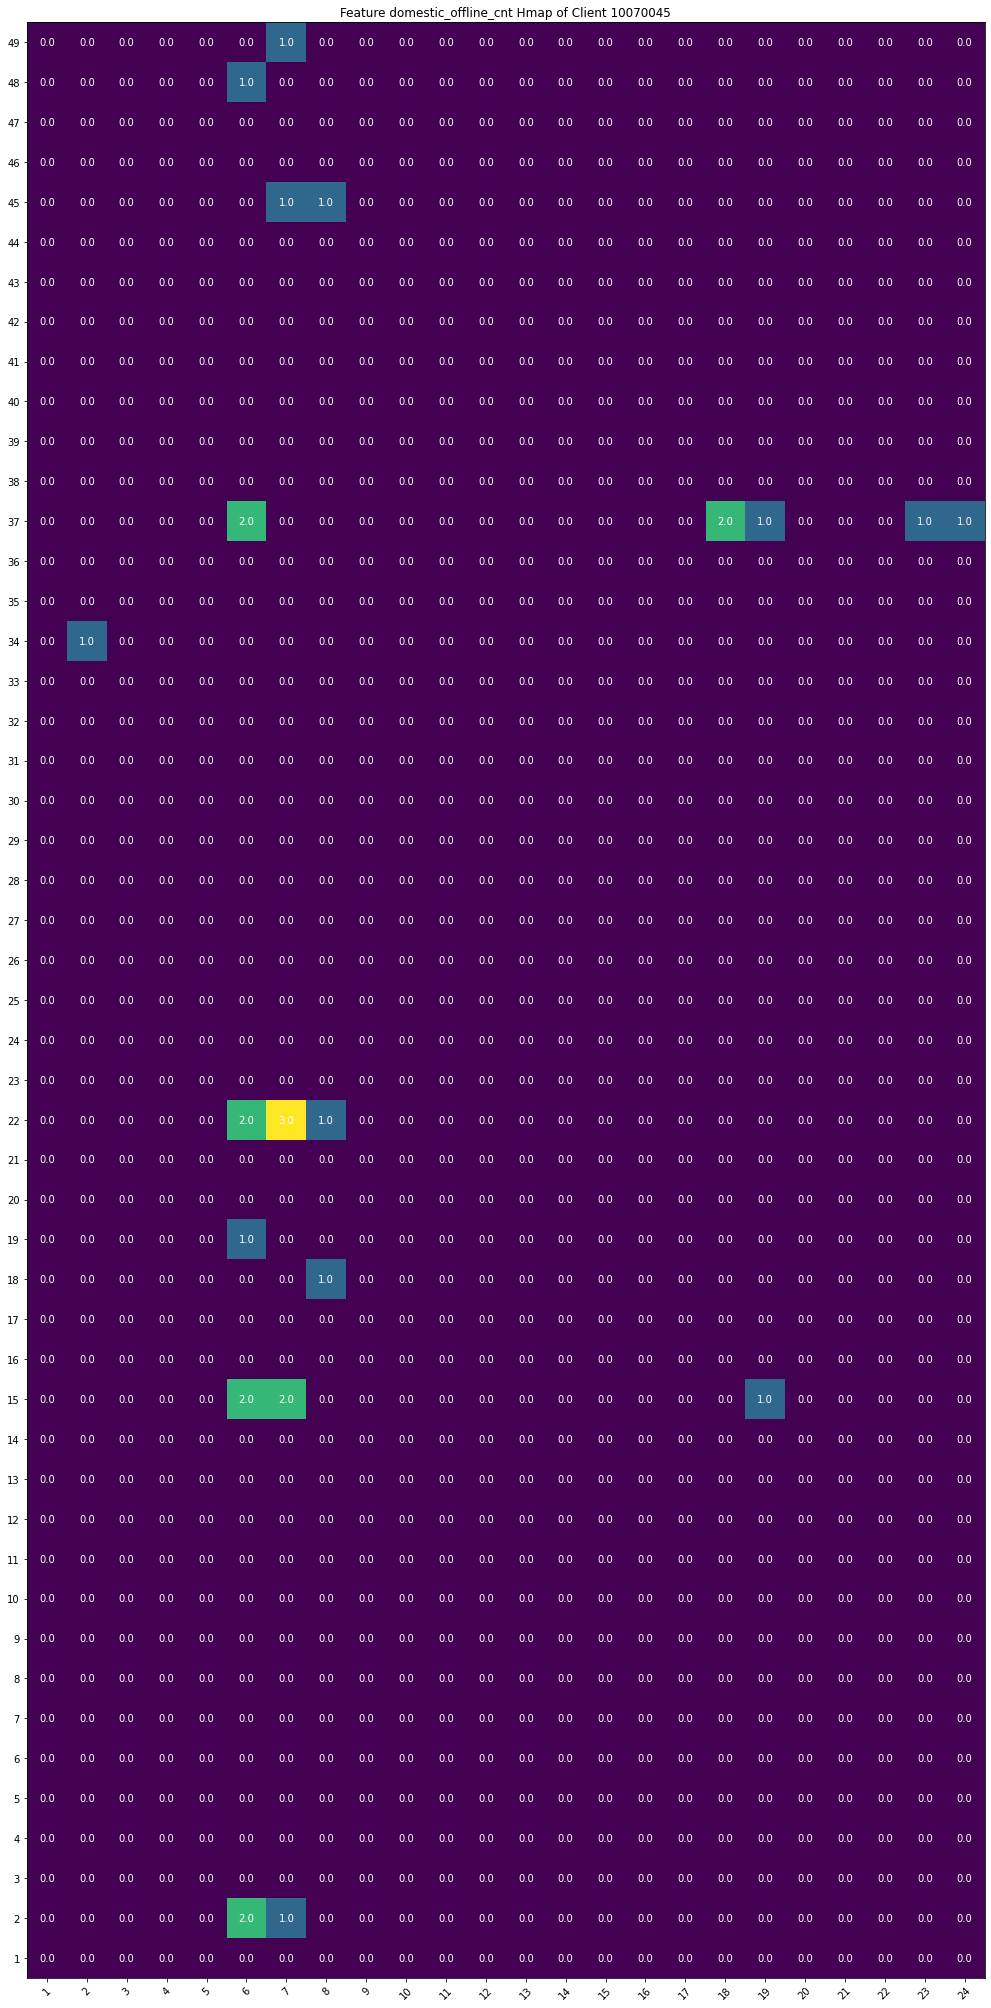

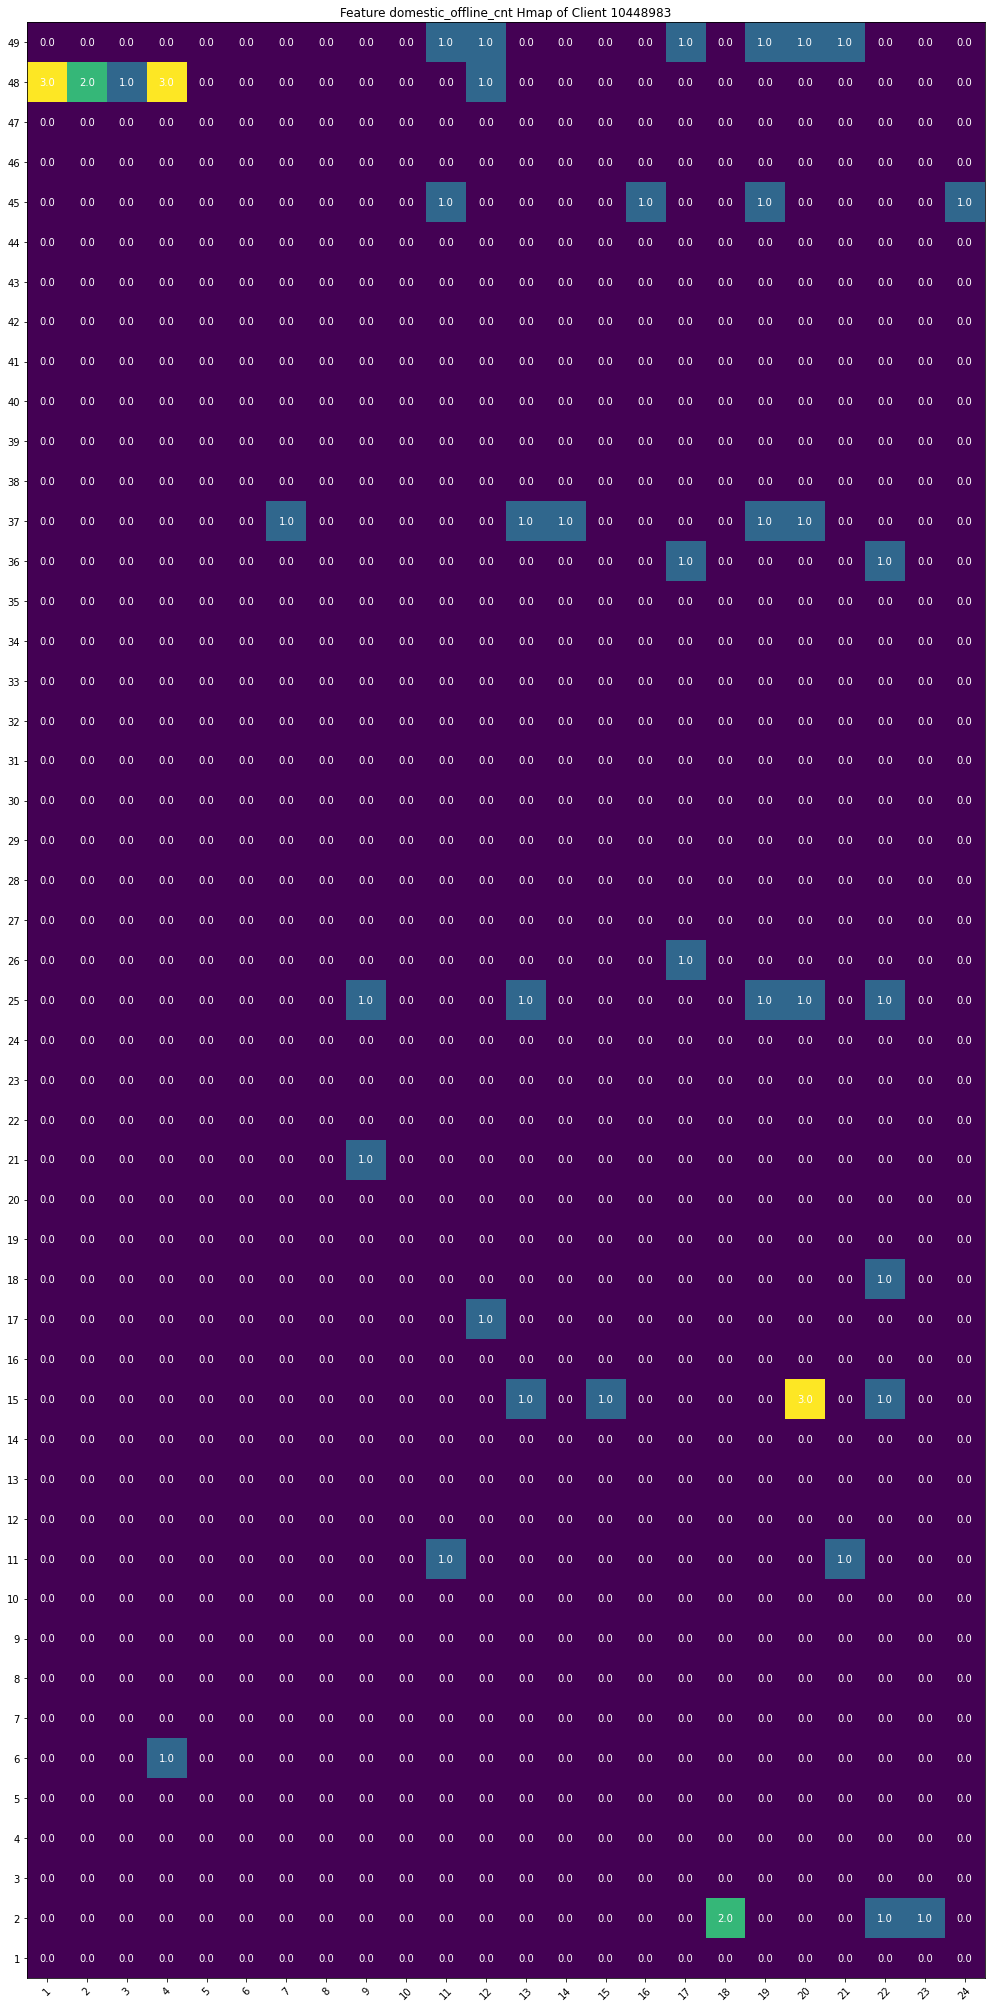

In [37]:
chids = sample(CHIDS, 10)
feat = 'domestic_offline_cnt'
LEG_SHOP_TAGS_ = LEG_SHOP_TAGS.copy()
LEG_SHOP_TAGS_.reverse()

for chid in chids:
    df__ = df[df['chid'] == chid].loc[:, ['dt', 'shop_tag', feat]]
    feat_vals = np.zeros((len(SHOP_TAGS), len(DTS)))
    for i, r in df__.iterrows():
        shop_tag = int(r['shop_tag'])
        dt = int(r['dt'])
        feat_vals[-shop_tag][dt-1] = r[feat].round(1)
#     feat_vals = feat_vals[LEG_SHOP_TAGS_INDICES, :]
    
    fig, ax = plt.subplots(figsize=(14, 28))
    hmap = ax.imshow(feat_vals)
    ax.set_xticks(np.arange(len(DTS)))
#     ax.set_yticks(np.arange(len(LEG_SHOP_TAGS)))
    ax.set_yticks(np.arange(len(SHOP_TAGS)))
    ax.set_xticklabels(DTS, rotation=45)
#     ax.set_yticklabels(LEG_SHOP_TAGS_)
    ax.set_yticklabels(SHOP_TAGS)
#     for i in range(len(LEG_SHOP_TAGS_)):
    for i in range(len(SHOP_TAGS)):
        for j in range(len(DTS)):
#             text = ax.text(j, len(LEG_SHOP_TAGS_)-1-i, feat_vals[len(LEG_SHOP_TAGS_)-1-i][j],
#                            ha="center", va="center", color="w")
            text = ax.text(j, len(SHOP_TAGS)-1-i, feat_vals[len(SHOP_TAGS)-1-i][j],
                           ha="center", va="center", color="w")
    ax.set_title(f"Feature {feat} Hmap of Client {chid}")
    fig.tight_layout()
    plt.show()

In [ ]:
# Utility function definitions 
def proc_feat_map(df, feat):
    '''Dump feature map of the specified single feature of all chids. 
    The axes of the feature map are `dt` and `shop_tag`.

    Parameter:
        df: pd.DataFrame, primary key with values of the specified 
            feature
        feat: str, feature name 
    
    Return:
        None
    '''
    chid_gps = df.groupby(by=['chid'])
    purch_map = chid_gp.groupby(by=['dt']).apply(get_purch_vec)
    empty_dts = [dt-1 for dt in DT_INDICES 
                 if dt not in purch_map.index]   # -1 to align with insertion idx
    purch_map = purch_map.values   # Shape (24, )
    purch_map = np.vstack(purch_map)
    # Insert empty basket index by index, becasuse inserting all at once leads to 
    # undesired results, for more information, see np.insert
    for empty_dt in empty_dts:
        purch_map = np.insert(purch_map, obj=empty_dt, values=EMPTY_BASKET, axis=0)
    
    return purch_map

In [43]:
# Therer are some situations that txn pct has values but txn cnt is zero
# indicating that returning for refund occurs
a, b = df['domestic_offline_cnt'], df['domestic_offline_amt_pct']
c = a == 0
d = b != 0
np.sum(np.array(c) * np.array(d)

In [2]:
fvg = get_feat_vecs(feat_map_path="./data/processed/feat_map/txn_amt.npz", t1=0, t2=22, gp_size=3, 
                    decay_wt_g=0.5, decay_wt_b=0.9)

100%|██████████| 500000/500000 [00:13<00:00, 35726.82it/s]


In [5]:
fvg2 = get_feat_vecs(feat_map_path="./data/processed/feat_map/txn_cnt.npz", t1=0, t2=22, gp_size=3, 
                     decay_wt_g=0.5, decay_wt_b=0.9)

100%|██████████| 500000/500000 [00:13<00:00, 36052.20it/s]


In [ ]:
# dt direction from top1 to bottom24
# shop_tag direction from left1 to right49

### MF

In [14]:
from utils.mf import MF
import numpy as np 

In [35]:
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

mf = MF(a, K=, alpha=0.1, beta=0.01, iterations=1000)
training_process = mf.train()

Iteration: 10 ; error = 0.4767
Iteration: 20 ; error = 0.0856
Iteration: 30 ; error = 0.0493
Iteration: 40 ; error = 0.0515
Iteration: 50 ; error = 0.0434
Iteration: 60 ; error = 0.0460
Iteration: 70 ; error = 0.0526
Iteration: 80 ; error = 0.0525
Iteration: 90 ; error = 0.0484
Iteration: 100 ; error = 0.0484
Iteration: 110 ; error = 0.0498
Iteration: 120 ; error = 0.0480
Iteration: 130 ; error = 0.0382
Iteration: 140 ; error = 0.0423
Iteration: 150 ; error = 0.0506
Iteration: 160 ; error = 0.0378
Iteration: 170 ; error = 0.0403
Iteration: 180 ; error = 0.0375
Iteration: 190 ; error = 0.0471
Iteration: 200 ; error = 0.0476
Iteration: 210 ; error = 0.0485
Iteration: 220 ; error = 0.0512
Iteration: 230 ; error = 0.0380
Iteration: 240 ; error = 0.0381
Iteration: 250 ; error = 0.0367
Iteration: 260 ; error = 0.0374
Iteration: 270 ; error = 0.0418
Iteration: 280 ; error = 0.0406
Iteration: 290 ; error = 0.0459
Iteration: 300 ; error = 0.0391
Iteration: 310 ; error = 0.0391
Iteration: 320 ; 

In [34]:
mf.full_matrix()

array([[1.28059849, 1.26178752, 1.16611665, 1.25145844, 1.31333437,
        1.27914457, 1.36302938, 1.27802381, 1.28422736, 2.76416968,
        1.20998543, 1.11744566, 1.247047  , 1.14722469, 0.02294508,
        1.22789885, 1.28148805, 1.26344139, 1.30230974, 1.22782795,
        1.21494164, 1.2700654 , 1.2680488 , 1.26271288, 1.19863662,
        1.28506876, 1.3175764 , 1.23653928, 1.281744  , 1.20836514,
        1.25898999, 1.28759833, 1.31460478, 1.26679494, 1.27185569,
        1.31250846, 0.02218776, 1.25665182, 1.2856768 , 1.19919077,
        1.25679497, 1.32195819, 1.26294806, 1.25596234, 2.21255965,
        1.81279291, 1.32326994, 1.22656909, 0.66339801],
       [1.97865893, 1.85297441, 2.02599304, 1.83815039, 1.71621437,
        1.78337659, 1.89605551, 1.84290461, 1.71229131, 6.60065491,
        2.0217416 , 1.79232783, 1.68907699, 1.82966088, 0.02251431,
        1.80777594, 1.58120681, 1.92808254, 1.75505604, 1.60632478,
        1.91669337, 1.82440802, 1.7091531 , 1.79565524, 2.1